In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

In [4]:
all_rows = pd.option_context("display.max_rows", None)

In [5]:
months = {m: i for i, m in enumerate("FGHJKMNQUVXZ")}

In [6]:
dailies = pd.read_csv(
    "csi_data.csv.gz", 
    names=[
        "contract", "expiry", "date", 
        "open", "high", "low", "close", 
        "volume", "open_interest",
    ],
    parse_dates=["date"],
)

# Adjust for multiplier inconsistencies in old data
for contract, mult in [
    ("SXE", 1/10), ("SXX", 1/10), 
    ("CU", 10), ("JY", 10), ("CD", 10)
]:
    dailies.loc[
        (dailies.contract == contract) & 
        (dailies.date < "2008"), 
        "close",
    ] *= mult

In [7]:
dailies[["prev_date", "prev_close"]] = (
    dailies.sort_values("date")
    .groupby(["contract", "expiry"])
    [["date", "close"]].shift()
)
dailies["d_close"] = dailies["close"] - dailies["prev_close"]

In [8]:
dailies["expiry_int"] = (
    dailies["expiry"].str.slice(0, 4).astype(int) * 12 + 
    dailies["expiry"].str.slice(4, 5).apply(months.get)
)

In [9]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

In [10]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

In [11]:
dailies = dailies[dailies.mod_month.between(0, 11)].copy()

In [12]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.keys())

In [13]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .set_index("Symbol")
)

In [14]:
daily_contracts = dailies.contract.drop_duplicates()

In [15]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

In [16]:
contract_mask = (
    metadata.Currency.isin(["USD", "EUR"])
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(["TF", "ER2", "ZI"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
    &
    ~names.str.contains("last in")
    &
    ~names.str.contains("last trade in close")  
    &
    ~names.str.contains("floor trading only")
    &
    ~names.str.contains("\(floor\)")    
)

In [17]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("^(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:\.\d+)?)", expand=False).astype(float)
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

In [18]:
dailies = dailies.loc[lambda df: df.contract.map(contract_mask).fillna(False)]

In [19]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .assign(adr=lambda df: df.eval("high - low"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "adr": "mean"})
    .reset_index()
)

In [20]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol"] = contract_volumes.eval("adr * multiplier * volume")
contract_volumes["cat_rank"] = (
    contract_volumes.groupby(["category", "decade"])
    .dollar_vol.rank(ascending=False)
    .astype(int)
)
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.groupby("contract").date.min().dt.year.astype("Int64")
)

In [21]:
shortlist = (
    contract_volumes    
    .query("cat_rank <= 5 & start_year < 2000")
    .query("decade == 2010")
    .query("dollar_vol.rank(ascending=False) <= 50")
#         .sort_values(["category", "dollar_vol"], ascending=[True, False])
    .sort_values("dollar_vol", ascending=False)
    [["dollar_vol", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with pd.option_context("display.max_rows", None):
    display(
        shortlist
        .style
        .format(subset=["dollar_vol"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,4.2e+08,USD,ES,CME,ES,Indexes-U.S.,1,e-mini S&P 500 Index-CME,1982
1,3.2e+08,USD,US,CBT,ZB,Govt Bonds,1,U.S. T-Bond (Floor+Electronic Combined)-CBT,1977
2,1.8e+08,USD,TY,CBT,TYF,Govt Notes,1,10-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1982
3,1.7e+08,EUR,SXE,EUREX,FESX,Indexes-European,1,Euro STOXX 50 Index-EUREX,1998
4,1.2e+08,EUR,FDX,EUREX,FDAX,Indexes-European,2,DAX Index-EUREX,1990
5,1.2e+08,EUR,EBL,EUREX,FGBL,Govt Bonds,2,Euro German Bund-EUREX,1990
6,1.1e+08,USD,CL2,NYMEX,YC,Energy,1,Crude Oil (Floor+Electronic Combined)-NYMEX,1983
7,9.8e+07,USD,FV,CBT,FV,Govt Notes,2,5-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1988
8,9.0e+07,USD,LCO,ICE,B,Energy,2,Brent Crude (Combined)-(IPE),1988
9,6.5e+07,USD,CU,CME,Y2,FOREX,1,Euro (Floor+Electronic Combined)-CME,1976


In [22]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

In [23]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/49 [00:00<?, ?it/s]

In [24]:
active_months = top_ratio[top_ratio > 1/12].reset_index().drop("volume", axis=1)
dailies = dailies.merge(active_months)

In [25]:
volumes = dailies.set_index(["contract", "date", "expiry"]).volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

In [26]:
live_contracts = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/3)]
#     .loc[lambda df: ~df.groupby(["contract", "expiry"]).cummin().lt(1/6)]
    .reset_index()
)

In [27]:
live_contracts = live_contracts.merge(dailies, how="left")

In [28]:
front = (
    live_contracts
    .sort_values("expiry")
    .groupby(["contract", "date"]).first()
)

In [29]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

In [30]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/49 [00:00<?, ?it/s]

In [31]:
ndays = 30
signal = (
    front
    .eval("d_close / vol")
    .groupby("contract").cumsum()
    .pipe(lambda df: (
        df.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
        .lt(df)
    ))
    .pipe(lambda xs: xs * 2 - 1)
    .groupby("contract").shift(fill_value=False)
    .groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
)

<AxesSubplot:xlabel='date'>

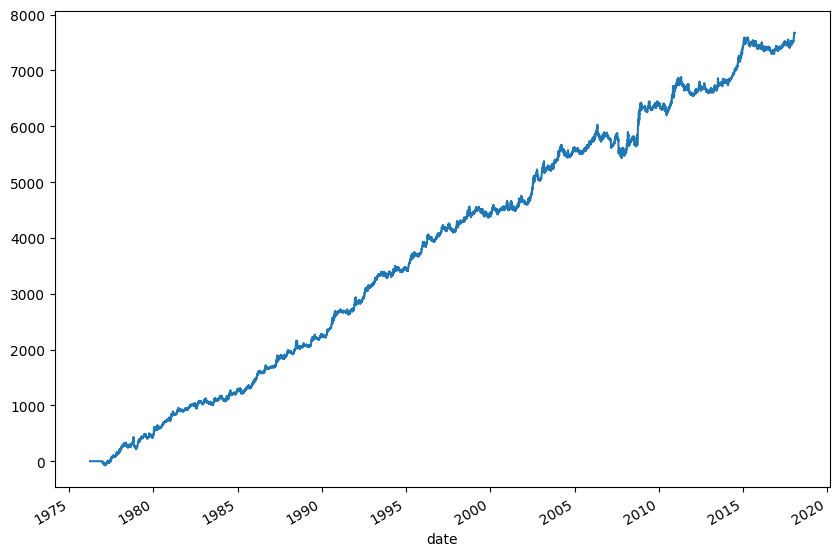

In [32]:
pnl = (
    front.eval("d_close / vol * @signal")
    .loc[shortlist.contract]
    .groupby("date").sum()
)
plt.figure(figsize=(10, 7), dpi=100)
pnl.cumsum().plot()

In [33]:
date_group = pd.Grouper(level="date", freq="10Y")

In [34]:
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(date_group):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

<AxesSubplot:xlabel='date'>

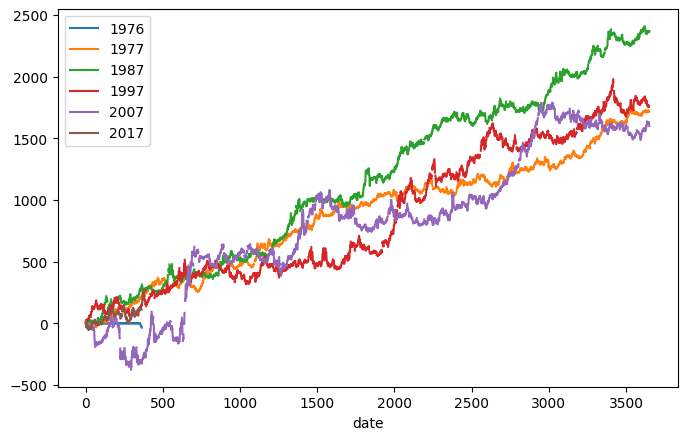

In [35]:
plt.figure(figsize=(8, 5), dpi=100)
by_period.cumsum().plot(ax=plt.gca())

In [36]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1976   -2.788272
1977    1.333284
1987    1.413176
1997    0.817327
2007    0.590728
2017    1.483255
dtype: float64

In [37]:
front.to_parquet("front.parquet")

In [38]:
# from bqplot import pyplot as plt
# from bqplot import OrdinalScale
# df_subset = df.tail(180)
# fig = plt.figure()
# plt.scales(scales={'x': OrdinalScale()})
# axes_options = {'x': {'label': 'Date', 'tick_format': '%Y-%m-%d', 
#                       'num_ticks': 8, "tick_rotate": 45, 'tick_style': {'text-anchor': 'start'}}, 
#                 'y': {'label': 'Price', 'label_offset': "3em", 'tick_format': '.0f'}}
# ohlc = plt.ohlc(
#     x=df_subset.index,
#     y=df_subset[ohlc_cols],
#     axes_options=axes_options,
#     marker="candle", 
#     stroke="black",
# )
# ohlc.colors=["lime", "tomato"]
# fig